In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2 - Get the data

In [3]:
data_train = pd.read_csv('data/train.csv')

## Step 3 - 5
## ...

## Step 6 - Feature Engineering

In [4]:
from sklearn.compose import ColumnTransformer # Column Transformer
from sklearn.impute import SimpleImputer # Imputation
from sklearn.preprocessing import OneHotEncoder # One-Hot Encoding
from sklearn.preprocessing import KBinsDiscretizer # Binning
from sklearn.pipeline import Pipeline #  Pipeline for chaining Column Transformers
from sklearn.preprocessing import MinMaxScaler # Scaler between 0 and 1 - distribution stays the same
from sklearn.preprocessing import StandardScaler # Scaler with normal distribution - mean 0 and 1 standard deviation
from sklearn.preprocessing import PowerTransformer # make the data more Gaussian-like
from sklearn.preprocessing import FunctionTransformer # for custom-build functions
import feature_names

In [5]:
# Define X and y of Model 
X_train = data_train.drop('Survived', axis=1)
y_train = data_train['Survived']

## Age feature

/Users/marf/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


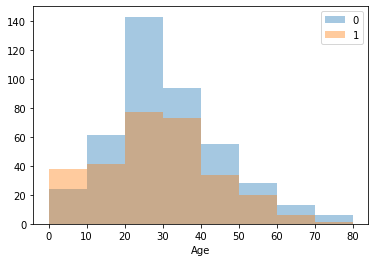

In [238]:
bins=[0,10,20,30,40,50,60,70,80]

for outcome in data_train['Survived'].unique():
    mask = data_train['Survived'] == outcome
    sns.distplot(data_train[mask]['Age'], kde=False, label=outcome, bins=bins)
    
plt.legend()

Text(0.5, 0, 'years')

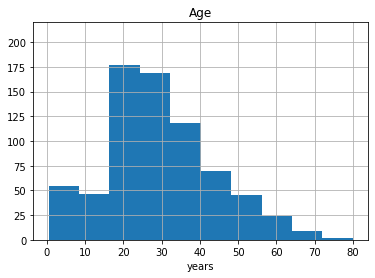

In [21]:
X_train['Age'].hist(bins=10)
plt.ylim(0, 220)
plt.title('Age')
plt.xlabel('years')

### Fill NaN with Forward Fill

In [7]:
X_train['Age_ffill'] = data_train['Age'].fillna(method='ffill') ## Fill NaN with previous values

Text(0.5, 0, 'years')

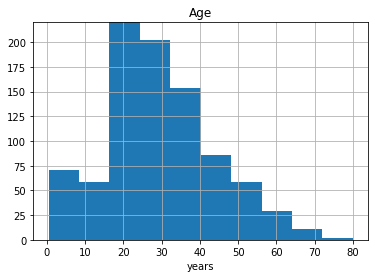

In [19]:
X_train['Age_ffill'].hist(bins=10)
plt.ylim(0, 220)
plt.title('Age')
plt.xlabel('')

### Transform Age distribution in bins (3 or 10)

In [240]:
age_feat = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

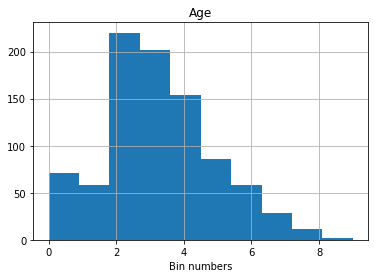

In [241]:
pd.DataFrame(age_feat.fit_transform(X_train[['Age_ffill']])).hist()
plt.title('Age')
plt.xlabel('Bin numbers', )
None

In [242]:
age_feat.bin_edges_

array([array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
       64.084, 72.042, 80.   ])], dtype=object)

### feature engineering for all important features

In [209]:
pipeline_fare = Pipeline(steps=[('impute', SimpleImputer(strategy='median')), ('scale', PowerTransformer())])

feature_eng = ColumnTransformer([
    ('pass', 'passthrough', ['Pclass', 'SibSp', 'Parch']), # Pass through Pclass, SibSp
    ('encode_Sex', OneHotEncoder(sparse=True, drop='first'), ['Sex']), # Encode Sex in Female = 0, Male = 1
    # Put Age distribution  in 4 bins with uniform width, on an ordinal scale from 0 to 3 
    ('bins', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'), ['Age_ffill']), ### Age binning
    ('impute and scale', pipeline_fare, ['Fare']) ## Fare Scaling
]) 

### Feature Transformation

In [210]:
feature_eng_matrix = feature_eng.fit_transform(X_train)

### Get column names of the transformed features

In [239]:
# https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
cols = feature_names.get_feature_names(feature_eng)
cols

/Users/marf/spiced_projects/a-star-anise-student-code/week02/feature_names.py:33: UserWarning: Transformer bins (type KBinsDiscretizer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/Users/marf/spiced_projects/a-star-anise-student-code/week02/feature_names.py:33: UserWarning: Transformer impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/Users/marf/spiced_projects/a-star-anise-student-code/week02/feature_names.py:33: UserWarning: Transformer scale (type PowerTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['Pclass',
 'SibSp',
 'Parch',
 'encode_Sex__x0_male',
 'bins__Age_ffill',
 'impute and scale__Fare']

### Create Dataframe out of the feature matrix

In [212]:
X_train_feat = pd.DataFrame(feature_eng.fit_transform(X_train), columns=cols)
X_train_feat.head()

,Pclass,SibSp,Parch,encode_Sex__x0_male,bins__Age_ffill,impute and scale__Fare
0,3.0,1.0,0.0,1.0,0.0,-0.878820
1,1.0,1.0,0.0,0.0,1.0,1.336651
2,3.0,0.0,0.0,0.0,0.0,-0.790065
3,1.0,1.0,0.0,0.0,1.0,1.067352
4,3.0,0.0,0.0,1.0,1.0,-0.774439


### Train Model 

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [214]:
# Create model
m = RandomForestClassifier(random_state=20, n_jobs=300, max_depth=7)
# Fitting the model
m.fit(X_train_feat, y_train)

RandomForestClassifier(max_depth=7, n_jobs=300, random_state=20)

### Evaluate Classifier

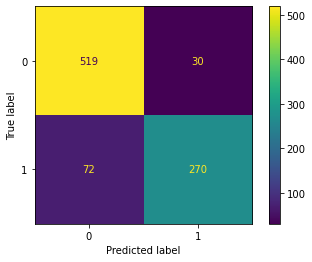

In [215]:
# Confusion matrix of the model
plot_confusion_matrix(estimator=m,
                     X=X_train_feat,
                     y_true=y_train)

In [216]:
accuracy_score(y_pred=m.predict(X_train_feat), y_true=y_train)

0.8855218855218855

### Check for Feature Importance

In [217]:
import_3bins= m.feature_importances_

In [218]:
import_3bins

array([0.12626239, 0.0631705 , 0.05886989, 0.43885123, 0.05105399,
       0.261792  ])

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

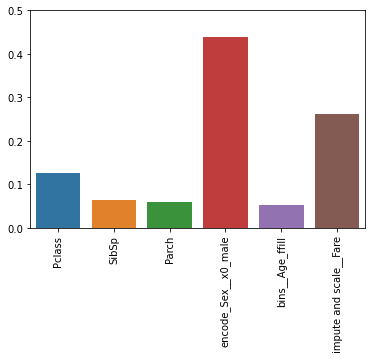

In [219]:
sns.barplot(x=cols, y=import_3bins)
plt.ylim(0, 0.5)
plt.xticks(rotation=90)

In [220]:
import_10bins

array([0.13427603, 0.06019989, 0.04596353, 0.42362681, 0.11486878,
       0.22106497])

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

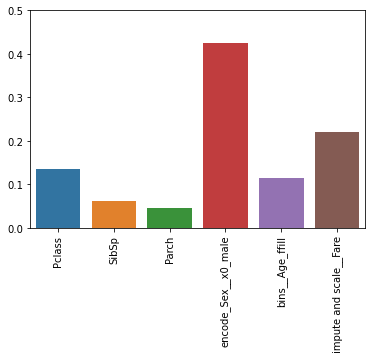

In [221]:
sns.barplot(x=cols, y=import_10bins)
plt.ylim(0, 0.5)
plt.xticks(rotation=90)